# **bài toán viên kẹo**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu giả lập
np.random.seed(42)
N = 1000
K = 3

# Trung bình thực tế (dùng để tạo dữ liệu)
true_means = [
    [10, 50],  # Kẹo dẻo
    [5, 70],   # Kẹo cứng
    [15, 30]   # Kẹo sô-cô-la
]

# Ma trận hiệp phương sai thực tế
true_covs = [
    [[1.2, 0.3], [0.3, 2.0]],  # Kẹo dẻo
    [[0.8, 0.1], [0.1, 1.5]],  # Kẹo cứng
    [[1.5, 0.2], [0.2, 1.8]]   # Kẹo sô-cô-la
]

# Tỷ lệ thực tế
true_weights = [0.4, 0.3, 0.3]

# Chuyển true_means thành mảng NumPy
true_means = np.array(true_means)
true_covs = np.array(true_covs)

In [ ]:
# Hàm sinh dữ liệu từ phân phối Gaussian đa biến
def multivariate_normal_sample(mean, cov, size=1):
    mean = np.array(mean)
    cov = np.array(cov)
    D = len(mean)

    # Phân tích Cholesky: cov = L @ L.T
    L = np.linalg.cholesky(cov)

    # Sinh mẫu ngẫu nhiên từ phân phối chuẩn (0, 1)
    z = np.random.normal(0, 1, (size, D))

    # Chuyển đổi: x = mean + L @ z
    samples = mean + z @ L.T
    return samples[0] if size == 1 else samples

# Tạo dữ liệu
data = []
labels = []
for i in range(N):
    # Chọn ngẫu nhiên một loại kẹo
    k = np.random.choice(K, p=true_weights)
    # Sinh đặc trưng từ phân phối Gaussian
    x = multivariate_normal_sample(true_means[k], true_covs[k])
    print(x)
    data.append(x)
    labels.append(k)
data = np.array(data)
labels = np.array(labels)

[ 8.78199636 50.13795791]
[11.72994096 51.49725772]
[ 9.36367989 49.11227643]
[10.26505639 47.41169549]
[ 5.73025068 68.23271479]
[ 9.00530946 47.7918355 ]
[ 4.43698048 70.65862103]
[ 4.51308929 70.0744208 ]
[ 4.46311663 71.08841664]
[ 9.34086343 52.40514754]
[ 9.41541702 49.84618466]
[16.00740766 28.5085655 ]
[13.04348945 52.41698027]
[10.80894961 50.44000124]
[ 8.89460239 47.52691903]
[ 9.49539551 51.34054644]
[ 8.761542   49.87689801]
[14.17094325 30.70400739]
[10.63768357 51.39112189]
[13.97217264 29.45118886]
[13.15289699 31.21808167]
[ 8.78807076 48.03734835]
[16.02241141 30.53124212]
[ 5.32345709 69.25362403]
[16.83152543 30.69454774]
[ 2.65682875 70.70952144]
[ 8.44583674 51.0578576 ]
[ 4.80351949 70.41098553]
[ 4.29406589 70.81881164]
[ 9.11433963 49.08242526]
[15.61414627 31.62420352]
[14.35117891 30.59699112]
[16.68018111 30.45780243]
[14.14016407 29.44901879]
[11.39530527 49.94375843]
[15.00626268 29.6884434 ]
[ 4.64623933 69.60313962]
[ 9.82332036 50.5164279 ]
[ 4.15650435

In [ ]:
# Hàm tính mật độ Gaussian đa biến
def gaussian_pdf(x, mean, cov):
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    D = len(mean)

    # Tính (x - mean)
    diff = x - mean

    # Tính định thức và nghịch đảo của cov
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)

    # Tính exponent: -0.5 * (x - mean)^T @ inv_cov @ (x - mean)
    exponent = -0.5 * diff.T @ inv_cov @ diff

    # Tính hệ số chuẩn hóa: 1 / [(2pi)^(D/2) * |cov|^(1/2)]
    coef = 1.0 / ((2 * np.pi) ** (D / 2) * np.sqrt(det_cov))

    # Tính mật độ xác suất
    return coef * np.exp(exponent)

In [ ]:
# Thuật toán EM
def em_algorithm(data, K, max_iters=100, tol=1e-6):
    N, D = data.shape
    # Khởi tạo tham số
    init_means = data[np.random.choice(N, K, replace=False)]  # Lưu trung bình khởi tạo
    means = init_means.copy()
    covs = [np.cov(data.T) for _ in range(K)]
    weights = np.ones(K) / K
    log_likelihood_old = -np.inf

    for iteration in range(max_iters):
        responsibilities = np.zeros((N, K))
        for k in range(K):
            for n in range(N):
                responsibilities[n, k] = weights[k] * gaussian_pdf(data[n], means[k], covs[k])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        Nk = responsibilities.sum(axis=0)
        for k in range(K):
            means[k] = np.sum(responsibilities[:, k][:, np.newaxis] * data, axis=0) / Nk[k]
            diff = data - means[k]
            covs[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            covs[k] += 1e-6 * np.eye(D)
            weights[k] = Nk[k] / N

        log_likelihood = 0
        for n in range(N):
            total = sum(weights[k] * gaussian_pdf(data[n], means[k], covs[k]) for k in range(K))
            log_likelihood += np.log(total)

        if abs(log_likelihood - log_likelihood_old) < tol:
            print(f"Hội tụ sau {iteration + 1} lần lặp")
            break
        log_likelihood_old = log_likelihood

    return init_means, means, covs, weights, responsibilities

Hội tụ sau 80 lần lặp
Trung bình khởi tạo:
Loại 1: [32.15402273 60.76213389]
Loại 2: [20.09871506 39.45508429]
Loại 3: [20.97051847 37.71927534]

Trung bình ước lượng:
Loại 1: [29.93630752 59.82142346]
Loại 2: [ 9.83656746 20.04811483]
Loại 3: [20.18137109 40.06150082]

Tỷ lệ ước lượng: [0.33333333 0.33333333 0.33333333]


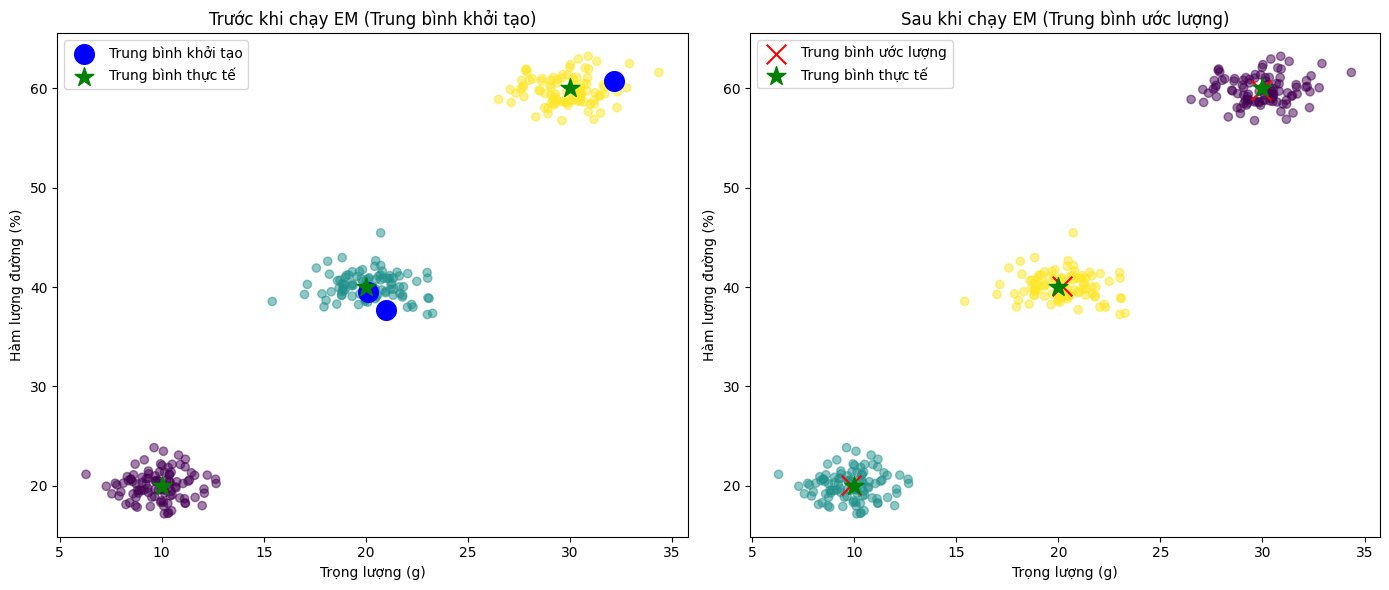

In [ ]:
# Chạy thuật toán
init_means, means, covs, weights, responsibilities = em_algorithm(data, K=3)

# Phân loại kẹo
predicted_labels = np.argmax(responsibilities, axis=1)

# Hiển thị kết quả
print("Trung bình khởi tạo:")
for k in range(K):
    print(f"Loại {k + 1}: {init_means[k]}")
print("\nTrung bình ước lượng:")
for k in range(K):
    print(f"Loại {k + 1}: {means[k]}")
print("\nTỷ lệ ước lượng:", weights)

# Vẽ biểu đồ phân cụm với trung bình khởi tạo và ước lượng
plt.figure(figsize=(14, 6))

# Biểu đồ trước khi chạy EM
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(init_means[:, 0], init_means[:, 1], c='blue', marker='o', s=200, label='Trung bình khởi tạo')
plt.scatter(true_means[:, 0], true_means[:, 1], c='green', marker='*', s=200, label='Trung bình thực tế')
plt.xlabel("Trọng lượng (g)")
plt.ylabel("Hàm lượng đường (%)")
plt.title("Trước khi chạy EM (Trung bình khởi tạo)")
plt.legend()

# Biểu đồ sau khi chạy EM
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis', alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=200, label='Trung bình ước lượng')
plt.scatter(true_means[:, 0], true_means[:, 1], c='green', marker='*', s=200, label='Trung bình thực tế')
plt.xlabel("Trọng lượng (g)")
plt.ylabel("Hàm lượng đường (%)")
plt.title("Sau khi chạy EM (Trung bình ước lượng)")
plt.legend()

plt.tight_layout()
plt.show()

# **Xử lý âm thanh**

[[-26.88906065 -75.79351949 -80.        ]
 [-43.64102012 -80.         -80.        ]
 [-45.05125363 -80.         -80.        ]
 ...
 [-80.         -80.         -65.52695509]
 [-80.         -80.         -65.5267753 ]
 [-51.16328337 -49.65033254 -29.15254799]]


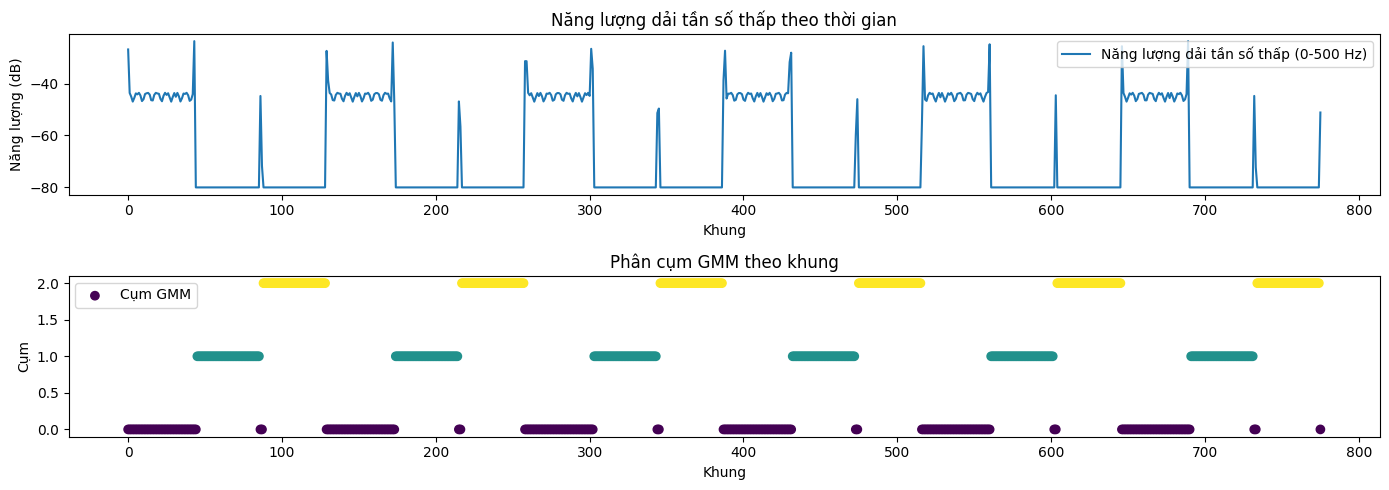

GMM hội tụ: True
Trọng số cụm: [0.36469072 0.31701031 0.31829897]


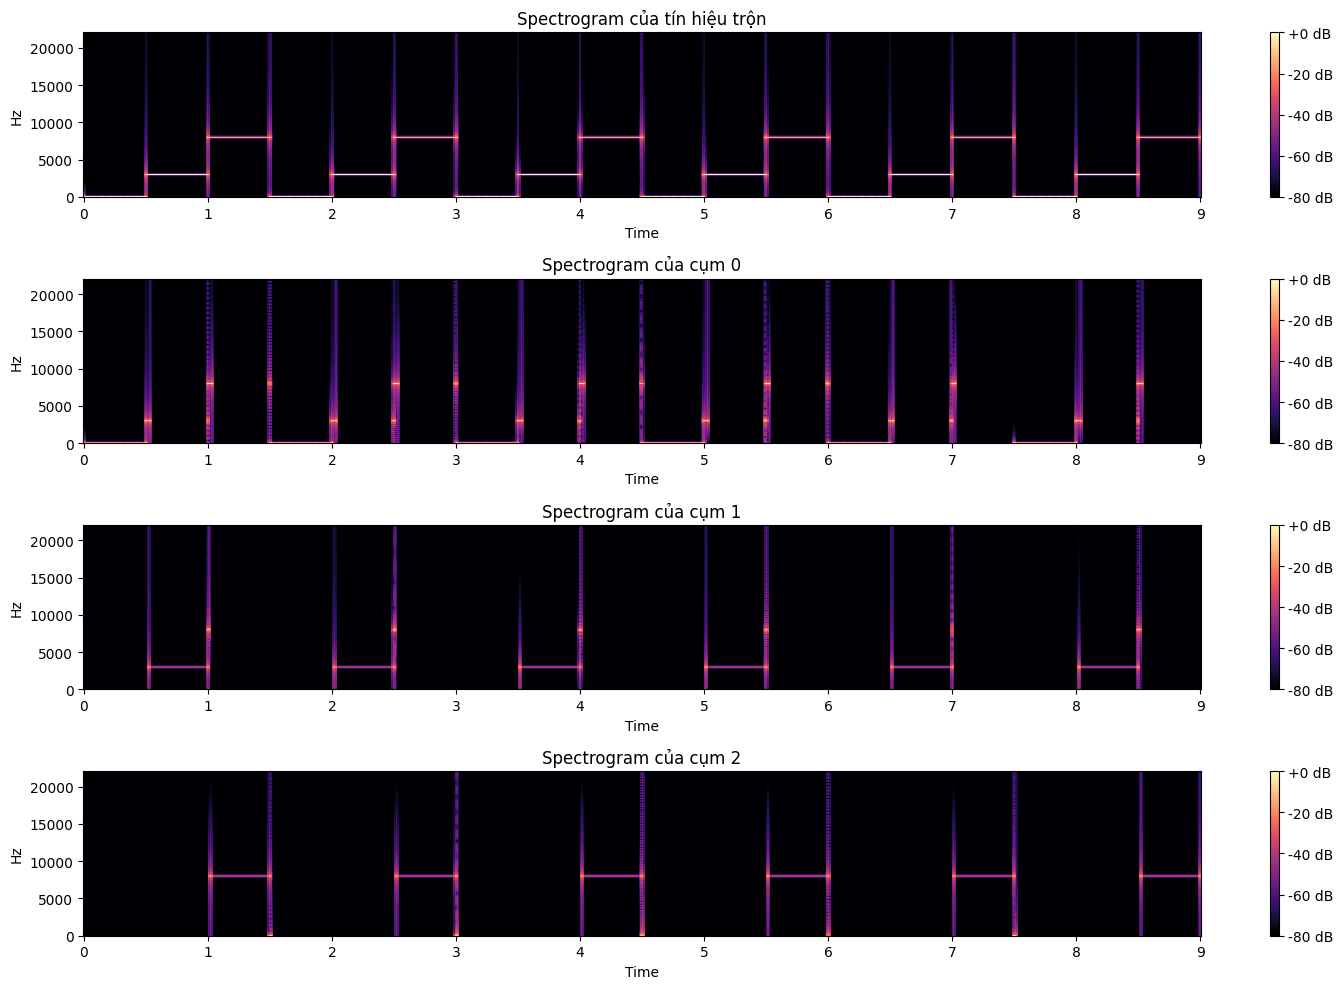

In [1]:
import numpy as np
import wave
import struct
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import librosa

# Tạo sóng âm sin
def create_sine_wave(frequency, duration, sample_rate=44100, amplitude=1.0):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    return amplitude * np.sin(2 * np.pi * frequency * t)

def generate_mixed_audio(filename, freqs, total_duration, segment_duration=0.5, sample_rate=44100):
    try:
        samples_per_segment = int(sample_rate * segment_duration)
        total_samples = int(sample_rate * total_duration)

        mixed_audio = np.zeros(total_samples)

        num_cycles = int(total_duration / (segment_duration * len(freqs)))

        for cycle in range(num_cycles):
            for i, freq in enumerate(freqs):
                start = (cycle * len(freqs) + i) * samples_per_segment
                end = start + samples_per_segment
                if end > total_samples:
                    end = total_samples
                segment = create_sine_wave(freq, (end - start) / sample_rate, sample_rate, amplitude=0.33)
                mixed_audio[start:end] = segment[:end - start]

        mixed_audio = np.clip(mixed_audio, -1.0, 1.0)
        scaled = np.int16(mixed_audio / np.max(np.abs(mixed_audio)) * 32767)

        with wave.open(filename, 'w') as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(2)
            wav_file.setframerate(sample_rate)
            wav_file.writeframes(struct.pack('<' + 'h'*len(scaled), *scaled))

        return mixed_audio, sample_rate
    except Exception as e:
        print(f"Lỗi khi tạo tệp âm thanh: {e}")
        raise

# Đọc file âm thanh
def read_audio_file(filename):
    try:
        with wave.open(filename, 'r') as wav_file:
            frames = wav_file.readframes(-1)
            return np.frombuffer(frames, dtype=np.int16)
    except Exception as e:
        print(f"Lỗi khi đọc tệp âm thanh: {e}")
        raise

def extract_features(audio_data, sample_rate, n_fft=1024, hop_length=512):
    audio_data = audio_data.astype(float) / 32767.0

    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)

    magnitude = np.abs(stft)
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)

    freq_bins = np.linspace(0, sample_rate / 2, log_magnitude.shape[0])
    low_freq_idx = np.where((freq_bins >= 0) & (freq_bins <= 500))[0]  # Dải tần số thấp (50 Hz)
    mid_freq_idx = np.where((freq_bins >= 2000) & (freq_bins <= 4000))[0]  # Dải tần số trung (3000 Hz)
    high_freq_idx = np.where((freq_bins >= 7000) & (freq_bins <= 9000))[0]  # Dải tần số cao (8000 Hz)

    # Tính năng lượng trung bình trong các dải tần số
    low_energy = np.mean(log_magnitude[low_freq_idx, :], axis=0)
    mid_energy = np.mean(log_magnitude[mid_freq_idx, :], axis=0)
    high_energy = np.mean(log_magnitude[high_freq_idx, :], axis=0)

    # Kết hợp thành đặc trưng 2D (số khung x số đặc trưng)
    features = np.vstack((low_energy, mid_energy, high_energy)).T  # Shape: (n_frames, 3)

    return features

# Tách tín hiệu dựa trên nhãn cụm
def separate_audio(audio_data, labels, n_clusters, sample_rate, duration):
    separated_signals = []
    frame_size = 1024
    hop_length = 512
    n_frames = len(labels)

    # Tạo cửa sổ Hanning để làm mịn
    window = np.hanning(frame_size)

    for cluster in range(n_clusters):
        # Tạo tín hiệu rỗng cho cụm này
        separated_signal = np.zeros(len(audio_data))
        overlap_count = np.zeros(len(audio_data))

        for frame_idx, label in enumerate(labels):
            if label == cluster:
                start = frame_idx * hop_length
                end = start + frame_size
                if end <= len(audio_data):
                    # Áp dụng cửa sổ cho khung
                    frame = audio_data[start:end] * window
                    separated_signal[start:end] += frame
                    overlap_count[start:end] += window

        # Chuẩn hóa để tránh chia cho 0
        overlap_count[overlap_count == 0] = 1
        separated_signal /= overlap_count
        separated_signals.append(separated_signal)

    # Lưu các tín hiệu tách ra thành file WAV
    for i, signal in enumerate(separated_signals):
        signal = np.clip(signal, -1.0, 1.0)
        scaled = np.int16(signal / np.max(np.abs(signal)) * 32767)
        with wave.open(f'separated_audio_cluster_{i}.wav', 'w') as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(2)
            wav_file.setframerate(sample_rate)
            wav_file.writeframes(struct.pack('<' + 'h'*len(scaled), *scaled))

    return separated_signals

# ======= Chạy chính =======

# Bước 1: Tạo file âm thanh (phát lần lượt 50 Hz, 3000 Hz, 8000 Hz trong các đoạn ngắn)
freqs = [50, 3000, 8000]  # Xe cộ, giọng người, tiếng chó
duration = 9  # Tổng độ dài 9 giây
segment_duration = 0.5  # Mỗi tần số phát trong 0.5 giây
mixed_audio, sample_rate = generate_mixed_audio('mixed_audio.wav', freqs, duration, segment_duration=segment_duration)

audio_data = read_audio_file('mixed_audio.wav')
features = extract_features(audio_data, sample_rate)
print(features)
# Bước 3: Phân cụm bằng GMM
if features.size == 0 or np.all(features == 0):
    print("Không trích xuất được đặc trưng hợp lệ. Không thể chạy GMM.")
else:
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(features)

    # Bước 4: Tách tín hiệu dựa trên nhãn cụm
    separated_signals = separate_audio(mixed_audio, labels, n_clusters=3, sample_rate=sample_rate, duration=duration)

    # Bước 5: Vẽ biểu đồ đặc trưng + nhãn cụm
    plt.figure(figsize=(14, 5))

    # Hiển thị đặc trưng Log-Magnitude Spectrum (vẽ năng lượng ở dải tần số thấp)
    plt.subplot(2, 1, 1)
    plt.plot(features[:, 0], label='Năng lượng dải tần số thấp (0-500 Hz)')
    plt.title('Năng lượng dải tần số thấp theo thời gian')
    plt.xlabel('Khung')
    plt.ylabel('Năng lượng (dB)')
    plt.legend()

    # Hiển thị nhãn cụm
    plt.subplot(2, 1, 2)
    plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', marker='o', label='Cụm GMM')
    plt.title('Phân cụm GMM theo khung')
    plt.xlabel('Khung')
    plt.ylabel('Cụm')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Thông tin kết quả
    print("GMM hội tụ:", gmm.converged_)
    print("Trọng số cụm:", gmm.weights_)

    # Vẽ spectrogram để kiểm tra kết quả tách
    plt.figure(figsize=(15, 10))

    # Spectrogram tín hiệu trộn
    plt.subplot(len(separated_signals) + 1, 1, 1)
    S = np.abs(librosa.stft(mixed_audio))
    D = librosa.amplitude_to_db(S, ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram của tín hiệu trộn')

    # Spectrogram của các tín hiệu tách
    for i, signal in enumerate(separated_signals):
        plt.subplot(len(separated_signals) + 1, 1, i + 2)
        S = np.abs(librosa.stft(signal))
        D = librosa.amplitude_to_db(S, ref=np.max)
        librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram của cụm {i}')

    plt.tight_layout()
    plt.show()

# **Tạo sinh chữ số**

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

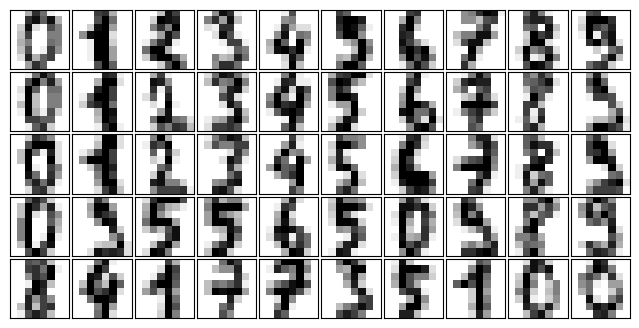

In [6]:
def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(8, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

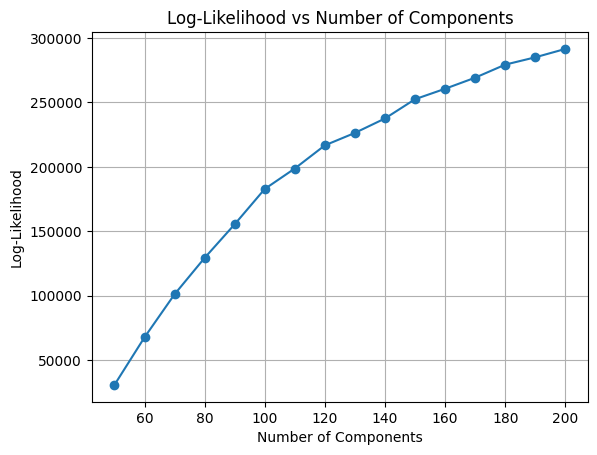

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Danh sách số lượng thành phần
n_components = np.arange(50, 210, 10)

# Huấn luyện các mô hình với số thành phần khác nhau
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data)
          for n in n_components]

# Tính log-likelihood tổng cho mỗi mô hình
log_likelihoods = [model.score(data) * len(data) for model in models]

# Vẽ đồ thị log-likelihood
plt.plot(n_components, log_likelihoods, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Number of Components')
plt.grid(True)
plt.show()


In [9]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [10]:
data_new, label_new = gmm.sample(100)
data_new.shape

(100, 41)

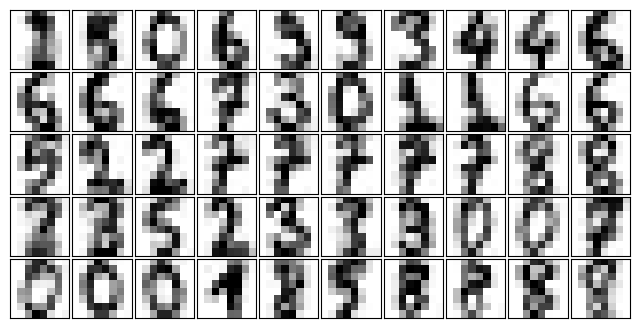

In [11]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)